# Annotating cell types in human single-cell RNA-seq data against the Cell Ontology with the CellO Python package

This Jupyter notebook implements the STAR Protocol for using CellO to annotate human single-cell RNA-seq data.

### Before we begin

We will download a single-cell RNA lung tissue dataset from GEO produced by Laughney et al. (2020).

In [18]:
GEO_DATASET_URL = 'ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3516nnn/GSM3516673/suppl/GSM3516673_MSK_LX682_NORMAL_dense.csv.gz'

subprocess.run('curl {} > GSM3516666_MSK_LX682_NORMAL_dense.csv.gz'.format(GEO_DATASET_URL), shell=True)

CompletedProcess(args='curl ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3516nnn/GSM3516673/suppl/GSM3516673_MSK_LX682_NORMAL_dense.csv.gz > GSM3516666_MSK_LX682_NORMAL_dense.csv.gz', returncode=0)

### Steps 1-2: Install CellO and its dependencies

Steps 1-2 entail installing CellO, its dependencies and verifying that they are installed correctly. We will install CellO within an Anaconda environment. Make sure that Anaconda is installed, and then run the following commands:

```
conda activate
conda create -y -n cello_env python=3.7 
conda activate cello_env
conda install -y git
conda install -y graphviz
pip install jupyter
pip install pygraphviz
pip install leidenalg
pip install git+https://github.com/deweylab/CellO
```

### Step 3. Import necessary Python packages

In [34]:
import os
import pandas as pd
import scanpy as sc
from anndata import AnnData
import cello

### Step 4: Load the expression matrix using Pandas and Scanpy

In [35]:
df = pd.read_csv("GSM3516666_MSK_LX682_NORMAL_dense.csv.gz", index_col=0)
adata = AnnData(df)

df

/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,TSPAN6,DPM1,SCYL3,C1ORF112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,RP11-24F11.5,RP5-958B11.1,WDFY4.1,RP11-244E17.1,RP11-57A19.7,RP11-419I17.1,RP3-454G6.2,AC013271.5,RP11-122G18.12,RP5-937E21.8
120703408789411,0,1,0,0,3,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120703408793835,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120703409145716,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120703409339181,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120703409379676,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241114576481206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241114577287974,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241114589031734,0,3,0,0,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241114589096668,0,2,0,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Step 5: Normalize the data by estimating log transcripts per million (TPM)

In [36]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

### Step 6: Perform principal components analysis (PCA)

In [37]:
sc.pp.pca(adata, n_comps=50)

### Step 7: Compute nearest-neighbors graph

In [38]:
sc.pp.neighbors(adata, n_neighbors=15)

### Step 8: Cluster the cells with Leiden

In [39]:
sc.tl.leiden(adata, resolution=1.0)

### Step 9: Specify CellO’s resource location

If you do not want to place CellO's resources at the current directory, change the following variable to the location where these resources will be stored. Note, these resources require approximately 5GB of disk space.

In [40]:
#cello_resource_loc = os.getcwd()
cello_resource_loc = "../test_cello"

### Step 10: Variant 1 for running CellO
    
Because CellO's pre-trained models expect different genes than those in the current expression matrix, we will need to train a new CellO classifier using CellO's built-in training set.

In [28]:
model_prefix = "GSM3516666_LX682_NORMAL" # <-- The trained model will be stored in a file called GSM3516666_LX682_NORMAL.model.dill 

cello.scanpy_cello(
    adata, 
    'leiden',
    cello_resource_loc, 
    out_prefix=model_prefix
)

Found CellO resources at '../test_cello/resources'.
Checking if any pre-trained model is compatible with this input dataset...


/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Could not find compatible pre-trained model.
Found CellO resources at '../test_cello/resources'.
Loading expression data from ../test_cello/resources/training_set/log_tpm.h5...
Loaded matrix of shape (4293, 58243)
done.
Inferred that input file uses HGNC gene symbols.
Of 18804 genes in test set, found 15754 of 58243 training set genes in input file.
Training model...
Fitting PCA with 3000 components...
done.
Transforming with PCA...
done.
(1/317)
Training classifier for label CL:0000576...
Number of positive items: 314
Number of negative items: 3950
(2/317)
Training classifier for label CL:0002087...
Number of positive items: 2010
Number of negative items: 2267
(3/317)
Training classifier for label CL:2000001...
Number of positive items: 1575
Number of negative items: 2242
(4/317)
Training classifier for label CL:0000842...
Number of positive items: 2010
Number of negative items: 2267
(5/317)
Training classifier for label CL:0000763...
Number of positive items: 1094
Number of negative 

(71/317)
Training classifier for label CL:0000897...
Number of positive items: 136
Number of negative items: 3897
(72/317)
Training classifier for label CL:0000813...
Number of positive items: 185
Number of negative items: 3994
(73/317)
Training classifier for label CL:0000864...
Number of positive items: 83
Number of negative items: 4166
(74/317)
Training classifier for label CL:0000583...
Number of positive items: 26
Number of negative items: 4223
(75/317)
Training classifier for label CL:0000895...
Number of positive items: 53
Number of negative items: 3978
(76/317)
Training classifier for label CL:0000898...
Number of positive items: 71
Number of negative items: 4108
(77/317)
Training classifier for label CL:0001062...
Number of positive items: 8
Number of negative items: 4110
(78/317)
Training classifier for label CL:0000909...
Number of positive items: 48
Number of negative items: 4069
(79/317)
Training classifier for label CL:0000913...
Number of positive items: 8
Number of nega

(144/317)
Training classifier for label CL:0002067...
Number of positive items: 23
Number of negative items: 4127
(145/317)
Training classifier for label CL:0000055...
Number of positive items: 43
Number of negative items: 4250
(146/317)
Training classifier for label CL:0000062...
Number of positive items: 31
Number of negative items: 4251
(147/317)
Training classifier for label CL:0002174...
Number of positive items: 41
Number of negative items: 4228
(148/317)
Training classifier for label CL:0000501...
Number of positive items: 15
Number of negative items: 4246
(149/317)
Training classifier for label CL:0000174...
Number of positive items: 15
Number of negative items: 4268
(150/317)
Training classifier for label CL:0002038...
Number of positive items: 15
Number of negative items: 4015
(151/317)
Training classifier for label CL:1000272...
Number of positive items: 5
Number of negative items: 4280
(152/317)
Training classifier for label CL:0010003...
Number of positive items: 5
Number 

(217/317)
Training classifier for label CL:0000670...
Number of positive items: 23
Number of negative items: 4261
(218/317)
Training classifier for label CL:0000049...
Number of positive items: 11
Number of negative items: 4188
(219/317)
Training classifier for label CL:0002536...
Number of positive items: 4
Number of negative items: 4265
(220/317)
Training classifier for label CL:0002631...
Number of positive items: 20
Number of negative items: 4026
(221/317)
Training classifier for label CL:0002090...
Number of positive items: 4
Number of negative items: 4283
(222/317)
Training classifier for label CL:0000971...
Number of positive items: 1
Number of negative items: 4115
(223/317)
Training classifier for label CL:0001053...
Number of positive items: 1
Number of negative items: 4115
(224/317)
Training classifier for label CL:0000972...
Number of positive items: 5
Number of negative items: 4111
(225/317)
Training classifier for label CL:0000979...
Number of positive items: 1
Number of n

(290/317)
Training classifier for label CL:1001599...
Number of positive items: 2
Number of negative items: 4259
(291/317)
Training classifier for label CL:0000152...
Number of positive items: 2
Number of negative items: 4283
(292/317)
Training classifier for label CL:1001433...
Number of positive items: 2
Number of negative items: 4267
(293/317)
Training classifier for label CL:0000123...
Number of positive items: 1
Number of negative items: 4284
(294/317)
Training classifier for label CL:0000242...
Number of positive items: 1
Number of negative items: 4264
(295/317)
Training classifier for label CL:0000810...
Number of positive items: 2
Number of negative items: 4177
(296/317)
Training classifier for label CL:0000811...
Number of positive items: 2
Number of negative items: 4177
(297/317)
Training classifier for label CL:0000128...
Number of positive items: 5
Number of negative items: 4280
(298/317)
Training classifier for label CL:0001059...
Number of positive items: 1
Number of nega

/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Transforming with PCA...
done.
Making predictions for each classifier...
Running solver on item 1/20...
Running solver on item 2/20...
Running solver on item 3/20...
Running solver on item 4/20...
Running solver on item 5/20...
Running solver on item 6/20...
Running solver on item 7/20...
Running solver on item 8/20...
Running solver on item 9/20...
Running solver on item 10/20...
Running solver on item 11/20...
Running solver on item 12/20...
Running solver on item 13/20...
Running solver on item 14/20...
Running solver on item 15/20...
Running solver on item 16/20...
Running solver on item 17/20...
Running solver on item 18/20...
Running solver on item 19/20...
Running solver on item 20/20...
Checking if any pre-trained model is compatible with this input dataset...


/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Of 18804 genes in test set, found 15754 of 58243 training set genes in input file.
Of 18804 genes in test set, found 15402 of 31283 training set genes in input file.
Using thresholds stored in ../test_cello/resources/trained_models/ir.10x_genes_thresholds.tsv
Binarizing classifications...
Mapping each sample to its predicted labels...
Computing the most-specific predicted labels...
Item 0 predicted to be "alveolar macrophage (CL:0000583)"
Item 1 predicted to be "effector memory CD4-positive, alpha-beta T cell (CL:0000905)"
Item 10 predicted to be "central memory CD4-positive, alpha-beta T cell (CL:0000904)"
Item 11 predicted to be "effector memory CD4-positive, alpha-beta T cell (CL:0000905)"
Item 12 predicted to be "memory T cell (CL:0000813)"
Item 13 predicted to be "epithelial cell of upper respiratory tract (CL:0002631)"
Item 14 predicted to be "type II pneumocyte (CL:0002063)"
Item 15 predicted to be "type II pneumocyte (CL:0002063)"
Item 16 predicted to be "endothelial cell (CL:0

### Step 11: Variant 2 for running CellO
    
If you have a pre-trained model that is compatible with the genes in the target expression matrix, then we can run CellO without training a new model. For example, once we run Step 11, we don't need to run it again. We simply use the trained model from that step.



In [41]:
cello.scanpy_cello(
    adata, 
    'leiden',
    cello_resource_loc, 
    model_file=f'{model_prefix}.model.dill'
)

Loading model from GSM3516666_LX682_NORMAL.model.dill...
Found CellO resources at '../test_cello/resources'.


/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Transforming with PCA...
done.
Making predictions for each classifier...
Running solver on item 1/20...
Running solver on item 2/20...
Running solver on item 3/20...
Running solver on item 4/20...
Running solver on item 5/20...
Running solver on item 6/20...
Running solver on item 7/20...
Running solver on item 8/20...
Running solver on item 9/20...
Running solver on item 10/20...
Running solver on item 11/20...
Running solver on item 12/20...
Running solver on item 13/20...
Running solver on item 14/20...
Running solver on item 15/20...
Running solver on item 16/20...
Running solver on item 17/20...
Running solver on item 18/20...
Running solver on item 19/20...
Running solver on item 20/20...
Checking if any pre-trained model is compatible with this input dataset...


/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Of 18804 genes in test set, found 15754 of 58243 training set genes in input file.
Of 18804 genes in test set, found 15402 of 31283 training set genes in input file.
Using thresholds stored in ../test_cello/resources/trained_models/ir.10x_genes_thresholds.tsv
Binarizing classifications...
Mapping each sample to its predicted labels...
Computing the most-specific predicted labels...
Item 0 predicted to be "alveolar macrophage (CL:0000583)"
Item 1 predicted to be "effector memory CD4-positive, alpha-beta T cell (CL:0000905)"
Item 10 predicted to be "central memory CD4-positive, alpha-beta T cell (CL:0000904)"
Item 11 predicted to be "effector memory CD4-positive, alpha-beta T cell (CL:0000905)"
Item 12 predicted to be "memory T cell (CL:0000813)"
Item 13 predicted to be "epithelial cell of upper respiratory tract (CL:0002631)"
Item 14 predicted to be "type II pneumocyte (CL:0002063)"
Item 15 predicted to be "type II pneumocyte (CL:0002063)"
Item 16 predicted to be "endothelial cell (CL:0

### Step 12: Run UMAP

In [47]:
sc.tl.umap(adata)

### Step 13: Create UMAP plot with cells colored by cluster

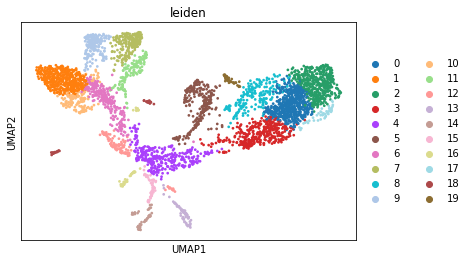

In [50]:
sc.pl.umap(adata, color='leiden')

### Step 14: Create UMAP plot with cells colored by most-specific predicted cell type

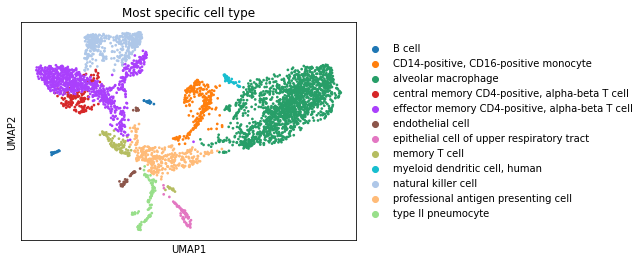

In [48]:
sc.pl.umap(adata, color='Most specific cell type')

### Step 15: Create UMAP plot with cells colored according their probability of being T cells

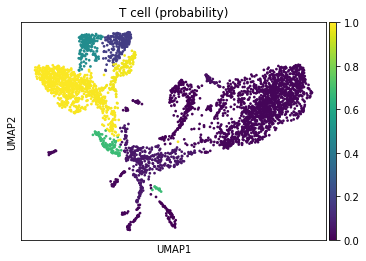

In [49]:
sc.pl.umap(adata, color='T cell (probability)', vmin=0.0, vmax=1.0)

### Step 16: Create UMAP plot with cells colored according whether they are classified as being T cells

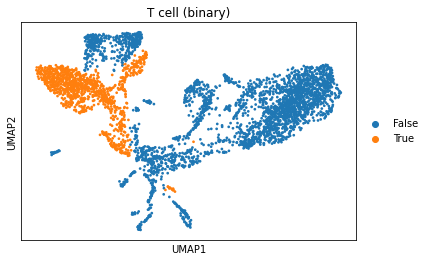

In [45]:
sc.pl.umap(adata, color='T cell (binary)')

### Step 17: Visualize cell type probabilities assigned to a specific cluster overlaid on the Cell Ontology graph

HERE!
True
True


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

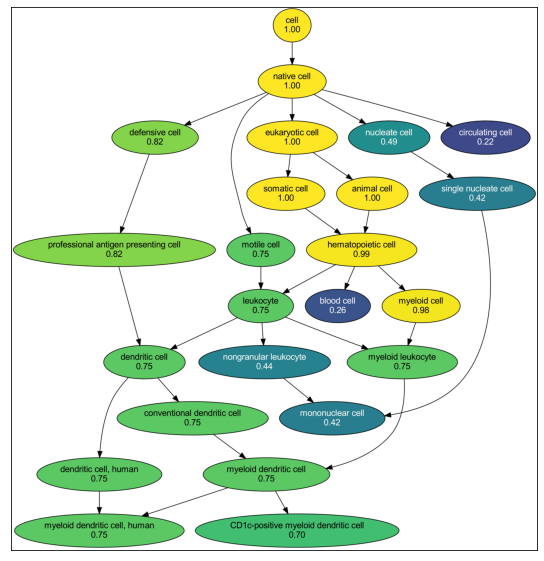

In [46]:
cello.cello_probs(adata, '19', cello_rsrc_loc, 0.2, clust_key='leiden')